In [1]:
#pip install holidays

In [2]:
# Basic imports
import numpy as np
import pandas as pd
import datetime # manipulating date formats
import itertools
import time
import holidays
import os

from math import sqrt
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE, r2_score, mean_absolute_percentage_error as MAPE
from sklearn import datasets, linear_model

# Stats packages
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

In [3]:
atl_v = pd.read_csv("/Users/sameshbajaj/Desktop/Time Series Analysis/Assignments/Project/nyc_violent_final copy.csv", parse_dates=['date'])
atl_temp = pd.read_csv("/Users/sameshbajaj/Desktop/Time Series Analysis/Assignments/Project/ISYE6203_ATL_avg_temp_2009-2020.csv", parse_dates=['date'])
holiday = pd.read_csv("/Users/sameshbajaj/Desktop/Time Series Analysis/Assignments/Project/Holidays_2009-2020.csv", parse_dates=['date'])

In [4]:
atl_v = atl_v.set_index("date")
atl_temp = atl_temp.set_index("date")
holiday = holiday.set_index("date")

<AxesSubplot:xlabel='date'>

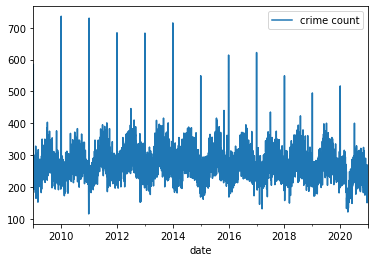

In [5]:
atl_v.plot()

In [6]:
atl_temp

,avgTemp
date,
2009-01-01,37.94
2009-01-02,43.52
2009-01-03,51.98
2009-01-04,59.45
2009-01-05,62.42
...,...
2020-12-27,43.52
2020-12-28,47.03
2020-12-29,52.52


<AxesSubplot:xlabel='date'>

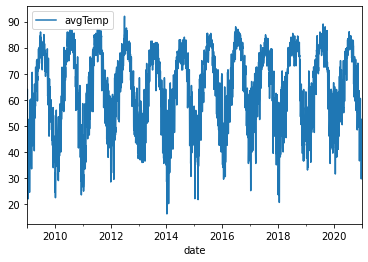

In [7]:
atl_temp.plot()

In [8]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,maxlag=7*4, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (round(dfoutput,3))

In [9]:
test_stationarity(atl_v)

Results of Dickey-Fuller Test:
Test Statistic                   -4.165
p-value                           0.001
#Lags Used                       28.000
Number of Observations Used    4354.000
Critical Value (1%)              -3.432
Critical Value (5%)              -2.862
Critical Value (10%)             -2.567
dtype: float64


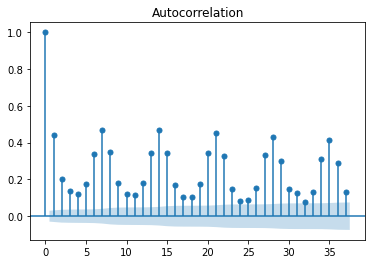

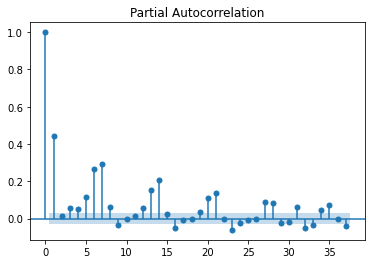

In [10]:
acf=plot_acf(atl_v)
pacf=plot_pacf(atl_v)

<AxesSubplot:xlabel='date'>

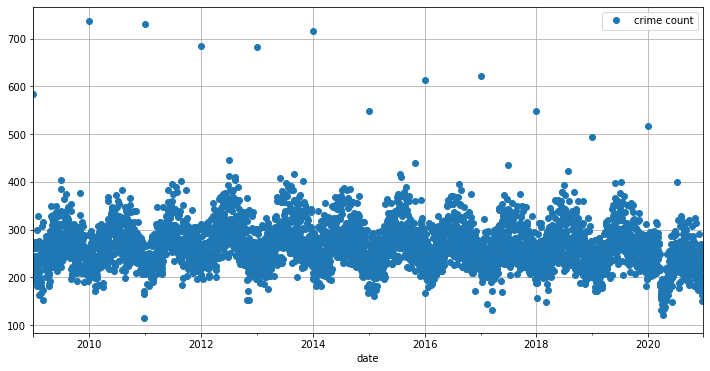

In [11]:
train_end = '2020-12-24'
#test_start = '2020-12-18'
test_end = '2020-12-31'
demo_start = '2020-10-31'
demo = atl_v[demo_start:test_end]
atl_v_train, atl_v_test = atl_v[:train_end], atl_v[train_end:]

atl_v_train.plot(figsize=(12,6), style='o', grid=True)

In [12]:
begin = '2009-01-01'
abv = '2020-12-30'

exo = atl_temp.copy()
exo_train,exo_test = exo[:train_end], exo[train_end:abv]
exo_test

,avgTemp
date,
2020-12-24,43.52
2020-12-25,29.66
2020-12-26,35.06
2020-12-27,43.52
2020-12-28,47.03
2020-12-29,52.52
2020-12-30,49.01


In [13]:
exo_train.shape

(4376, 1)

In [14]:
exo_test.shape

(7, 1)

In [15]:
atl_v_train.shape

(4376, 1)

In [16]:
atl_v_test.shape

(8, 1)

In [17]:
def sarimax(ts,exo,all_param):
    results = []
    for param in all_param:
        try:
            mod = SARIMAX(ts,
                          exog = exo,
                          order=param[0],
                          seasonal_order=param[1])
            res = mod.fit()
            results.append((res,res.aic,param))
            print('Tried out SARIMAX{}x{} - AIC:{}'.format(param[0], param[1], round(res.aic,2)))
        except Exception as e:
            print(e)
            continue
            
    return results

In [18]:
# set parameter range
p,d,q = range(0,2),[1],range(0,2)
P,D,Q,s = range(0,2),[1],range(0,2),[7]
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq,seasonal_pdq))

In [19]:
all_res = sarimax(atl_v_train,exo_train,all_param)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.21860D+00    |proj g|=  2.43964D-04
  ys=-1.023E+01  -gs= 9.187E-01 BFGS update SKIPPED

At iterate    5    f=  5.53420D+00    |proj g|=  2.43709D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     34      2     1     0   2.638D-07   5.534D+00
  F =   5.5342042545019785     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 0)x(0, 1, 0, 7) - AIC:48439.36


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.28407D+00    |proj g|=  6.10141D-02

At iterate    5    f=  5.22141D+00    |proj g|=  7.31897D-03

At iterate   10    f=  5.21617D+00    |proj g|=  2.93412D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     15      1     0     0   4.516D-06   5.216D+00
  F =   5.2161119521782933     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 0)x(0, 1, 1, 7) - AIC:45657.41
RUNNING THE L-B

 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.39031D+00    |proj g|=  4.03246D-03

At iterate    5    f=  5.39029D+00    |proj g|=  7.42130D-04

At iterate   10    f=  5.39027D+00    |proj g|=  2.00586D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     17      1     0     0   2.182D-06   5.390D+00
  F =   5.3902664979803987     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 0)x(1, 1, 0, 7) - AIC:47181.61
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

 This problem is unconstrained.



At iterate    5    f=  5.23814D+00    |proj g|=  1.14744D-02

At iterate   10    f=  5.21580D+00    |proj g|=  3.73721D-04

At iterate   15    f=  5.21556D+00    |proj g|=  9.98168D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     22      1     0     0   4.823D-06   5.216D+00
  F =   5.2155549734977882     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 0)x(1, 1, 1, 7) - AIC:45654.54
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate    5    f=  5.28300D+00    |proj g|=  4.61788D-03

At iterate   10    f=  5.27371D+00    |proj g|=  4.66824D-04

At iterate   15    f=  5.27247D+00    |proj g|=  1.01412D-03

At iterate   20    f=  5.27232D+00    |proj g|=  7.85755D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     25      1     0     0   4.370D-06   5.272D+00
  F =   5.2723162221433162     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 1)x(0, 1, 0, 7) - AIC:46149.31
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0

 This problem is unconstrained.



At iterate    5    f=  5.02493D+00    |proj g|=  2.82215D-02

At iterate   10    f=  4.97761D+00    |proj g|=  1.03433D-02

At iterate   15    f=  4.97367D+00    |proj g|=  7.73690D-05

At iterate   20    f=  4.97362D+00    |proj g|=  1.31035D-03

At iterate   25    f=  4.97360D+00    |proj g|=  1.51693D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     29      1     0     0   2.961D-06   4.974D+00
  F =   4.9735978444449467     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 1)x(0, 1, 1, 7) - AIC:43536.93
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f=  5.16943D+00    |proj g|=  6.32883D-03

At iterate   10    f=  5.13068D+00    |proj g|=  1.21246D-04

At iterate   15    f=  5.13042D+00    |proj g|=  1.23325D-03

At iterate   20    f=  5.12999D+00    |proj g|=  6.26960D-04

At iterate   25    f=  5.12996D+00    |proj g|=  3.65244D-04

At iterate   30    f=  5.12996D+00    |proj g|=  3.00189D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     38      1     0     0   3.402D-05   5.130D+00
  F =   5.1299560897164156     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 1, 1)x(1, 1, 0, 7) - AIC:44905

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.17305D+00    |proj g|=  8.13524D-02

At iterate    5    f=  5.07611D+00    |proj g|=  9.88869D-03

At iterate   10    f=  4.98485D+00    |proj g|=  7.99989D-02

At iterate   15    f=  4.97346D+00    |proj g|=  3.57177D-03

At iterate   20    f=  4.97341D+00    |proj g|=  4.27927D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     28      1     0     0   4.279D-05   4.973D+00
  F =   4.9734055360798628     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  5.43376D+00    |proj g|=  3.02711D-03

At iterate   10    f=  5.43374D+00    |proj g|=  1.50647D-03

At iterate   15    f=  5.43373D+00    |proj g|=  6.33360D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     17      1     0     0   6.334D-07   5.434D+00
  F =   5.4337273319355885     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 1, 0)x(0, 1, 0, 7) - AIC:47561.98
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate    5    f=  5.18053D+00    |proj g|=  7.69472D-03

At iterate   10    f=  5.12249D+00    |proj g|=  1.54435D-04

At iterate   15    f=  5.12217D+00    |proj g|=  1.09120D-02

At iterate   20    f=  5.12158D+00    |proj g|=  4.86282D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     32      1     0     0   7.834D-08   5.122D+00
  F =   5.1215770178198090     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 1, 0)x(0, 1, 1, 7) - AIC:44832.04
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0

 This problem is unconstrained.



At iterate    5    f=  5.29838D+00    |proj g|=  5.58732D-02

At iterate   10    f=  5.29034D+00    |proj g|=  2.09922D-02

At iterate   15    f=  5.28911D+00    |proj g|=  4.29523D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     19      1     0     0   4.295D-06   5.289D+00
  F =   5.2891055536547924     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 1, 0)x(1, 1, 0, 7) - AIC:46298.25


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.25780D+00    |proj g|=  7.98838D-02

At iterate    5    f=  5.20124D+00    |proj g|=  1.15976D-02

At iterate   10    f=  5.12140D+00    |proj g|=  1.09125D-03

At iterate   15    f=  5.12140D+00    |proj g|=  1.02506D-03

At iterate   20    f=  5.12102D+00    |proj g|=  1.05651D-02

At iterate   25    f=  5.12076D+00    |proj g|=  1.25242D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     40      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  5.27828D+00    |proj g|=  6.79994D-03

At iterate   10    f=  5.26296D+00    |proj g|=  1.01391D-03

At iterate   15    f=  5.26150D+00    |proj g|=  3.56191D-04

At iterate   20    f=  5.26136D+00    |proj g|=  3.51790D-04

At iterate   25    f=  5.26134D+00    |proj g|=  7.95772D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     30      1     0     0   7.958D-06   5.261D+00
  F =   5.2613372330111279     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 1, 1)x(0, 1, 0, 7) - AIC:46055.22
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f=  5.06899D+00    |proj g|=  1.00728D-02

At iterate   10    f=  4.97907D+00    |proj g|=  2.71809D-03

At iterate   15    f=  4.96641D+00    |proj g|=  2.22100D-02

At iterate   20    f=  4.96514D+00    |proj g|=  6.25689D-05

At iterate   25    f=  4.96510D+00    |proj g|=  8.82894D-04

At iterate   30    f=  4.96509D+00    |proj g|=  3.11475D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     47      1     0     0   3.115D-06   4.965D+00
  F =   4.9650928497298867     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 1, 1)x(0, 1, 1, 7) - AIC:43464

 This problem is unconstrained.



At iterate    5    f=  5.17582D+00    |proj g|=  3.61157D-02

At iterate   10    f=  5.11945D+00    |proj g|=  5.94757D-03

At iterate   15    f=  5.11901D+00    |proj g|=  5.62340D-05

At iterate   20    f=  5.11900D+00    |proj g|=  1.44444D-03

At iterate   25    f=  5.11892D+00    |proj g|=  1.77166D-03

At iterate   30    f=  5.11889D+00    |proj g|=  4.05312D-04

At iterate   35    f=  5.11888D+00    |proj g|=  6.60468D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     48      1     0     0   8.995D-06   5.119D+00
  F =   5.1188834476185550     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.16134D+00    |proj g|=  8.07345D-02

At iterate    5    f=  5.09009D+00    |proj g|=  2.91448D-02

At iterate   10    f=  4.98752D+00    |proj g|=  4.98571D-02

At iterate   15    f=  4.98135D+00    |proj g|=  8.06197D-03

At iterate   20    f=  4.98110D+00    |proj g|=  9.04642D-03

At iterate   25    f=  4.97539D+00    |proj g|=  4.48625D-02

At iterate   30    f=  4.96523D+00    |proj g|=  5.98259D-03

At iterate   35    f=  4.96478D+00    |proj g|=  5.30028D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

In [20]:
all_res.sort(key=lambda x: x[1])
all_res[:5]

[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7f956e652fa0>,
  43463.756217716524,
  ((1, 1, 1), (1, 1, 1, 7))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7f956e636370>,
  43464.49262083597,
  ((1, 1, 1), (0, 1, 1, 7))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7f95b397d640>,
  43536.928334582175,
  ((0, 1, 1), (0, 1, 1, 7))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7f9594f6dd30>,
  43537.24525177096,
  ((0, 1, 1), (1, 1, 1, 7))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7f95afa51190>,
  44810.46793355759,
  ((1, 1, 1), (1, 1, 0, 7)))]

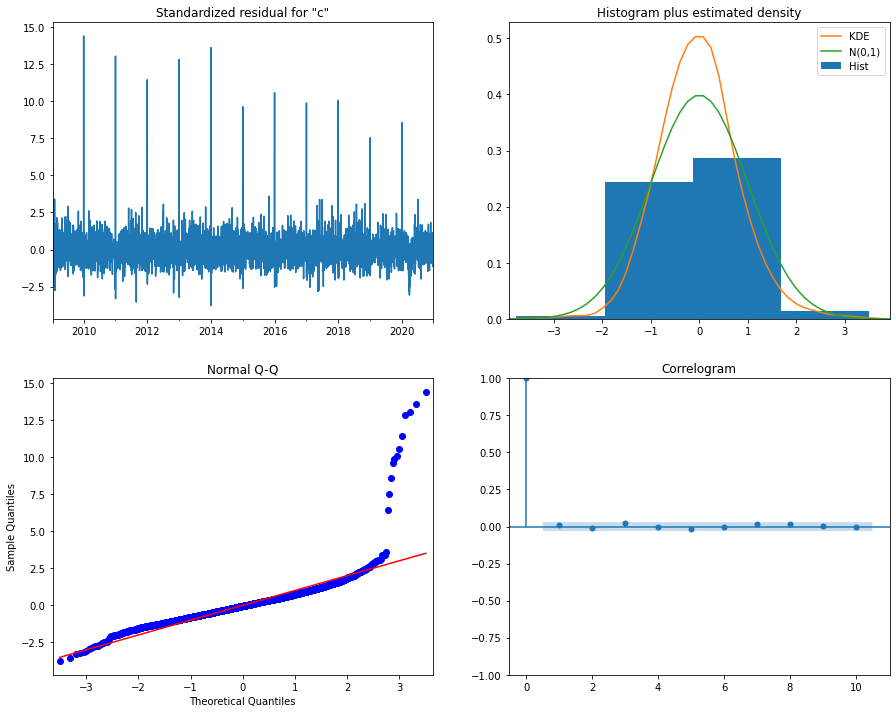

Ljung-box p-values:
[0.50125374 0.63616938 0.27457378 0.41247476 0.40148224 0.52858812
 0.50570352 0.49621673 0.59598999 0.67604244 0.73789046 0.79458993
 0.8285888  0.03375997]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                       crime count   No. Observations:                 4376
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -21725.878
Date:                           Tue, 26 Apr 2022   AIC                          43463.756
Time:                                   17:56:22   BIC                          43502.049
Sample:                               01-01-2009   HQIC                         43477.269
                                    - 12-24-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
avgTemp        1.1739      0.068     17.169      0.000       1.040       1.308
ar.L1          0.1454      0.010     15.114      0.000       0.127       0.164
ma.L1         -0.9577      0.005   -206.086      0.000      -0.967      -0.949
ar.S.L7        0.0408      0.014      2.843      0.004       0.013       0.069
ma.S.L7       -0.9987      0.004   -244.162      0.000      -1.007      -0.991
sigma2      1211.7776      7.311    165.751      0.000    1197.449    1226.107
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):            376491.32
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             3.88
Prob(H) (two-sided):                  0.00   Kurtosis:                        47.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
res = all_res[0][0]
res.plot_diagnostics(figsize=(15, 12))

plt.show()
print("Ljung-box p-values:\n" + str(res.test_serial_correlation(method='ljungbox')[0][1]))
res.summary()

In [22]:
def pm(y_true, y_pred):
    return sum((y_true-y_pred)**2)/sum((y_true-np.mean(y_true))**2)

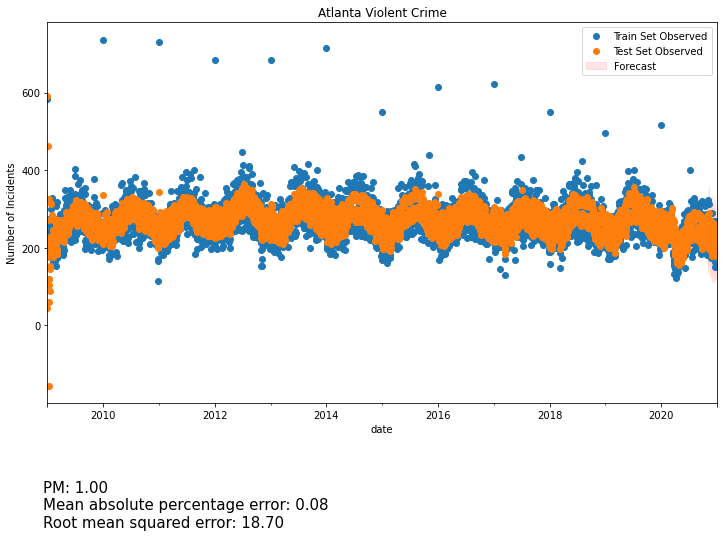

In [24]:
pred_test = res.get_prediction(start=train_end,end=test_end,exog=exo_test)
err = ('\nPM: %.2f'% pm(atl_v_test['crime count'], pred_test.predicted_mean.to_frame()['predicted_mean']) + \
      '\nMean absolute percentage error: %.2f'% MAPE(atl_v_test, pred_test.predicted_mean) + \
      '\nRoot mean squared error: %.2f'% sqrt(MSE(atl_v_test, pred_test.predicted_mean)))

pred = res.get_prediction(start=begin,end=test_end,exog=exo_test)
pred_ci = pred.conf_int()

fig, ax = plt.subplots(figsize=(12,7))
ax.set(title='Atlanta Violent Crime', ylabel='Number of Incidents')

atl_v.plot(ax=ax, style = 'o')
pred.predicted_mean.plot(ax=ax, style='o')
ci = pred_ci.loc[demo_start:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

plt.figtext(0.12, -0.06, err, ha="left",fontsize=15,va='center')
legend = ax.legend(["Train Set Observed","Test Set Observed", "Forecast"])



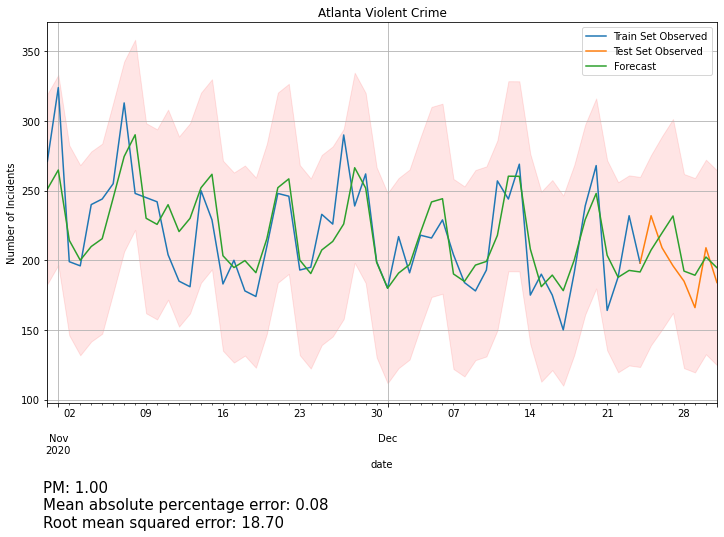

In [25]:
pred_test = res.get_prediction(start=train_end,end=test_end,exog=exo_test)
# The root mean squared error
err = ('\nPM: %.2f'% pm(atl_v_test['crime count'], pred_test.predicted_mean.to_frame()['predicted_mean']) + \
      '\nMean absolute percentage error: %.2f'% MAPE(atl_v_test, pred_test.predicted_mean) + \
      '\nRoot mean squared error: %.2f'% sqrt(MSE(atl_v_test, pred_test.predicted_mean)))

pred = res.get_prediction(start=demo_start,end=test_end,exog=exo_test)
pred_ci = pred.conf_int()

fig, ax = plt.subplots(figsize=(12,7))
ax.set(title='Atlanta Violent Crime', ylabel='Number of Incidents')

atl_v_train[demo_start:].plot(ax=ax)
atl_v_test.plot(ax=ax)
pred.predicted_mean.plot(ax=ax)
ci = pred_ci.loc[demo_start:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

plt.figtext(0.12, -0.06, err, ha="left",fontsize=15,va='center')
legend = ax.legend(["Train Set Observed","Test Set Observed", "Forecast"])
ax.grid(True)